DIGINETICA

https://competitions.codalab.org/competitions/11161#learn_the_details-evaluation

In [21]:
import pandas as pd
import numpy as np
import util

In [22]:
q = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-queries.csv', sep=';')
v = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-item-views.csv', sep=';')
c = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-clicks.csv', sep=';')
p = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-purchases.csv', sep=';')
products = pd.read_csv('./data/diginetica/dataset-train-diginetica/products.csv', sep=';')
product_cat = pd.read_csv('./data/diginetica/dataset-train-diginetica/product-categories.csv', sep=';')

/home/yua4/pareto/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
print(f'q:           {list(q.columns)}')
print(f'v:           {list(v.columns)}')
print(f'c:           {list(c.columns)}')
print(f'p:           {list(p.columns)}')
print(f'products:    {list(products.columns)}')
print(f'product_cat: {list(product_cat.columns)}')


q:           ['queryId', 'sessionId', 'userId', 'timeframe', 'duration', 'eventdate', 'searchstring.tokens', 'categoryId', 'items', 'is.test']
v:           ['sessionId', 'userId', 'itemId', 'timeframe', 'eventdate']
c:           ['queryId', 'timeframe', 'itemId']
p:           ['sessionId', 'userId', 'timeframe', 'eventdate', 'ordernumber', 'itemId']
products:    ['itemId', 'pricelog2', 'product.name.tokens']
product_cat: ['itemId', 'categoryId']


In [63]:
qq = q.iloc[:10_000].copy()

In [96]:
qi = qq.copy()
qi['items'] = qi['items'].str.split(',')
qi = qi.explode('items')
qi['pos'] = 1
qi['pos'] = qi.groupby('queryId')['pos'].cumsum()
qi = qi.rename(columns={'items': 'itemId'})
qi['itemId'] = qi['itemId'].astype(int)
qi = qi.rename(columns={'duration': 'duration_query', 'categoryId': 'categoryId_query'})
# clicks
qi = pd.merge(qi.rename(columns={'timeframe': 'timeframe_query', 'eventdate': 'evendate_query'}), c.rename(columns={'timeframe': 'timeframe_click'}), how='left', on=['queryId', 'itemId'])
qi['clicked'] = qi['timeframe_click'].notna()
# views (doesn't merge well)
# qi = pd.merge(qi, v.rename(columns={'timeframe': 'timeframe_view', 'eventdate': 'eventdate_view'}), how='left', on=['sessionId', 'userId', 'itemId'])
# purchases
qi = pd.merge(qi, p.rename(columns={'timeframe': 'timeframe_purchase', 'eventdate': 'eventdate_purchase'}), how='left', on=['userId', 'sessionId', 'itemId'])
qi['purchased'] = qi['timeframe_purchase'].notna()
# product prices
qi = pd.merge(qi, products, how='left', on=['itemId'])
# product cat
qi = pd.merge(qi, product_cat.rename(columns={'categoryId': 'categoryId_product'}), how='left', on=['itemId'])
# query totals
totals = qi.groupby('queryId')[['clicked', 'purchased']].sum().reset_index().rename(columns={'clicked':'clicks_query', 'purchased':'purchases_query', })
qi = qi.merge(totals, on='queryId')
qi

,queryId,sessionId,userId,timeframe_query,duration_query,evendate_query,searchstring.tokens,categoryId_query,itemId,is.test,...,clicked,timeframe_purchase,eventdate_purchase,ordernumber,purchased,pricelog2,product.name.tokens,categoryId_product,clicks_query,purchases_query
0,1,1,NaN,16327074,311,2016-05-09,"16655,244087,51531,529597,58153",0,7518,False,...,False,NaN,NaN,NaN,False,8,"776,39985,27945,27945",1010,1,0
1,1,1,NaN,16327074,311,2016-05-09,"16655,244087,51531,529597,58153",0,71,False,...,False,NaN,NaN,NaN,False,8,"60729,2226,2226",1010,1,0
2,1,1,NaN,16327074,311,2016-05-09,"16655,244087,51531,529597,58153",0,30311,False,...,False,NaN,NaN,NaN,False,8,"77851,27911,27911",1010,1,0
3,1,1,NaN,16327074,311,2016-05-09,"16655,244087,51531,529597,58153",0,7837,False,...,False,NaN,NaN,NaN,False,8,"83411,27945,27945",1010,1,0
4,1,1,NaN,16327074,311,2016-05-09,"16655,244087,51531,529597,58153",0,30792,False,...,False,NaN,NaN,NaN,False,8,"1804,116499,27945,27945",1010,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191345,10006,8793,6102.0,830758,512,2016-02-04,"201283,74039,2886,528876,535140",0,5826,False,...,False,NaN,NaN,NaN,False,0,"501099,501099,105304,186370,2886",918,1,0
191346,10006,8793,6102.0,830758,512,2016-02-04,"201283,74039,2886,528876,535140",0,24852,False,...,False,NaN,NaN,NaN,False,0,"501099,501099,501117,105363,2886,501116",918,1,0
191347,10006,8793,6102.0,830758,512,2016-02-04,"201283,74039,2886,528876,535140",0,24851,False,...,False,NaN,NaN,NaN,False,9,"501099,501099,65369,2886,60360",918,1,0
191348,10006,8793,6102.0,830758,512,2016-02-04,"201283,74039,2886,528876,535140",0,47135,False,...,False,NaN,NaN,NaN,False,10,"506683,1323,1323,505422",88,1,0


In [27]:
# 6.2.2
no_clicks = qi['clicked_total'] == 0
no_purchases = qi['purchased_total'] == 0
qi_groupby_cumsum = qi.groupby('queryId').cumsum()
metrics = pd.DataFrame()

qi.loc[no_clicks, 'c_map'] = 0
qi.loc[no_clicks, 'c_ndcg'] = 0
qi.loc[~no_clicks, 'cum_clicks'] = qi.groupby('queryId')['clicked'].cumsum()
qi.loc[~no_clicks, 'c_ap'] = (qi['cum_clicks'] / (qi['position'] + 1))
qi.loc[~no_clicks, 'c_ap_cumsum'] = (1 / (qi['position'] + 1)) * qi.groupby('queryId')['c_ap'].cumsum()
qi.loc[(~no_clicks) & (qi['clicked'] == 0), 'c_ap_cumsum'] = 0
# qi.loc[~no_clicks, 'c_map'] = qi.groupby('queryId')['c_ap_cumsum'].cumsum()
metrics['c_map'] = qi.groupby('position')['c_ap_cumsum'].sum() / len(qi[~no_clicks].groupby('queryId'))

qi.loc[~no_clicks, 'c_dcg'] = (np.power(2, qi['cum_clicks']) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_clicks, 'c_dcg_cumsum'] = qi.groupby('queryId')['c_dcg'].cumsum()
qi.loc[~no_clicks, 'c_idcg'] = (np.power(2, (qi['position'] + 1)) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_clicks, 'c_idcg_cumsum'] = qi.groupby('queryId')['c_idcg'].cumsum()
qi.loc[~no_clicks, 'c_ndcg'] = qi['c_dcg_cumsum'] / qi['c_idcg_cumsum']
metrics['c_ndcg'] = qi.groupby('position')['c_ndcg'].sum() / len(qi[~no_clicks].groupby('queryId'))

qi = qi.drop(columns=['c_ap', 'c_dcg', 'c_idcg', 'c_ap_cumsum', 'cum_clicks', 'c_dcg_cumsum', 'c_idcg_cumsum'])

qi.loc[no_purchases, 'g_map'] = 0
qi.loc[no_purchases, 'g_ndcg'] = 0
qi.loc[~no_purchases, 'cum_purchases'] = qi.groupby('queryId')['purchased'].cumsum()
qi.loc[~no_purchases, 'g_ap'] = (qi['cum_purchases'] / (qi['position'] + 1))
qi.loc[~no_purchases, 'g_ap_cumsum'] = (1 / (qi['position'] + 1)) * qi.groupby('queryId')['g_ap'].cumsum()
qi.loc[(~no_purchases) & (qi['purchased'] == 0), 'g_ap_cumsum'] = 0
# qi.loc[~no_purchases, 'g_map'] = qi.groupby('queryId')['g_ap_cumsum'].cumsum()
metrics['g_map'] = qi.groupby('position')['g_ap_cumsum'].sum() / len(qi[~no_purchases].groupby('queryId'))

qi.loc[~no_purchases, 'g_dcg'] = qi['price'] * (np.power(2, qi['cum_purchases']) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_purchases, 'g_dcg_cumsum'] = qi.groupby('queryId')['g_dcg'].cumsum()
qi.loc[~no_purchases, 'g_idcg'] = qi['price'] * (np.power(2, (qi['position'] + 1)) - 1) / np.log2((qi['position'] + 1) + 1)
qi.loc[~no_purchases, 'g_idcg_cumsum'] = qi.groupby('queryId')['g_idcg'].cumsum()
qi.loc[(~no_purchases) & (qi['price'] == 0), 'g_ndcg'] = 0
qi.loc[(~no_purchases) & (qi['price'] > 0), 'g_ndcg'] = qi['g_dcg'] / qi['g_idcg']
metrics['g_ndcg'] = qi.groupby('position')['g_ndcg'].sum() / len(qi[~no_purchases].groupby('queryId'))

qi = qi.drop(columns=['g_ap', 'g_dcg', 'g_idcg', 'g_ap_cumsum', 'cum_purchases', 'g_dcg_cumsum', 'g_idcg_cumsum'])

qi = qi.drop(columns=['userId', 'sessionId', 'clicked_total', 'purchased_total'])

In [28]:
metrics

,c_map,c_ndcg,g_map,g_ndcg
position,,,,
0,0.050139,0.049211,0.065217,6.521739e-02
1,0.013734,0.039309,0.010870,3.260870e-02
2,0.007015,0.030631,0.003623,1.863354e-02
3,0.003962,0.022665,0.004076,1.304348e-02
4,0.002848,0.016192,0.003043,7.713885e-03
5,0.001690,0.011083,0.003019,5.866115e-03
6,0.001431,0.007363,0.000665,3.166724e-03
7,0.001506,0.004828,0.000510,1.662404e-03
8,0.001103,0.003034,0.000671,9.572024e-04


In [29]:
# 5
pi = pd.DataFrame()
pi['n'] = qi.groupby('itemId').size()
pi[['clicked', 'purchased']] = qi.groupby('itemId')[['clicked', 'purchased']].sum()
pi['price'] = qi.groupby('itemId')['price'].mean()

pi.loc[pi['clicked'] > 0, 'l_ctr'] = -np.log(pi['clicked'] / pi['n'])
pi.loc[pi['clicked'] == 0, 'l_ctr'] = 0
l_ctr = (1 / len(pi)) * pi['l_ctr'].sum()

pi.loc[pi['purchased'] > 0, 'l_gmv'] = -pi['price'] * np.log(pi['purchased'] / pi['n'])
# pi.loc[pi['purchased'] > 0, 'l_gmv'] = pi['price'] * np.log(pi['purchased'] / pi['n']) + np.log(pi['purchased'] / pi['clicked'])
pi.loc[pi['purchased'] == 0, 'l_gmv'] = 0
l_gmv = (1 / len(pi)) * pi['l_gmv'].sum()

pi = pi.reset_index()
l_ctr, l_gmv

/home/yua4/pareto/venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yua4/pareto/venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.30722959435402, 0.07925870001320857)

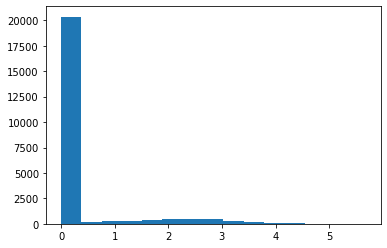

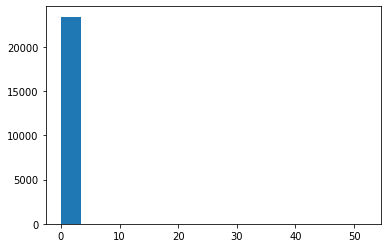

In [30]:
import matplotlib.pyplot as plt
plt.hist(pi[pi['l_ctr'].notna()]['l_ctr'], bins=15)
plt.show()
plt.hist(pi[pi['l_gmv'].notna()]['l_gmv'], bins=15)
plt.show()

In [35]:
qi

,queryId,position,itemId,clicked,purchased,price,c_map,c_ndcg,g_map,g_ndcg
0,1,0,7518,0.0,0.0,8,NaN,0.000000,0.0,0.0
1,1,1,71,0.0,0.0,8,NaN,0.000000,0.0,0.0
2,1,2,30311,0.0,0.0,8,NaN,0.000000,0.0,0.0
3,1,3,7837,0.0,0.0,8,NaN,0.000000,0.0,0.0
4,1,4,30792,0.0,0.0,8,NaN,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
191345,10006,15,5826,0.0,0.0,0,NaN,0.000048,0.0,0.0
191346,10006,16,24852,0.0,0.0,0,NaN,0.000028,0.0,0.0
191347,10006,17,24851,0.0,0.0,9,NaN,0.000016,0.0,0.0
191348,10006,18,47135,0.0,0.0,10,NaN,0.000009,0.0,0.0
